### Load Images

In [49]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_hub as hub

# Helper libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import cv2

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")



TF version: 2.10.1
Hub version: 0.15.0
GPU is available


#### Constant Variables

In [50]:
# Pfad zum Hauptordner, der die Unterordner mit Bildern enthält
main_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train"
train_val_data_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train"
test_data_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\test"

augmented_images_data_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\augmented_images"

# Auflösung der Bilder in das Format für das neuronale Netz
desired_height = 128
desired_width = 128

# Zählen der Unterordner in train_val_data_folder für die Anzahl der Klassen
number_of_classes = len([name for name in os.listdir(train_val_data_folder) if os.path.isdir(os.path.join(train_val_data_folder, name))])
class_names = [name for name in os.listdir(train_val_data_folder) if os.path.isdir(os.path.join(train_val_data_folder, name))]

print(f"Klassen: {class_names}")
print(f"Anzahl der Klassen: {number_of_classes}")


Klassen: ['end_speed', 'no_class', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']
Anzahl der Klassen: 9


#### Data Augmentation Pipeline

In [29]:
# Erstellen eines ImageDataGenerator für Data Augmentation
train_datagen = ImageDataGenerator(
    #rescale=1./255,   # Normalisieren der Bilder
    rotation_range=20,  # Zufällige Rotation der Bilder
    width_shift_range=0.2,  # Horizontaler Shift
    brightness_range = [0.5, 1.4],
    height_shift_range=0.2, # Vertikaler Shift
    shear_range=0.2,        # Scherung
    zoom_range=0.2,         # Zoom
    fill_mode='nearest',     # Füllmethode für neue Pixel
)

With this definition the ImageDataGenerator object, when used, will modify existing images to create new ones by applying the following modifications: 
- Rotation: Randomly rotates the images within the range of -20 to +20 degrees.
- Shear: Applies random shearing transformations to the images with a shear intensity of 0.2.
- Zoom: Randomly zooms in or out of the images with a zoom range of 0.2.
- Width Shift: Shifts the width of the images horizontally by a fraction of the total width, with a maximum shift of 0.1.
- Height Shift: Shifts the height of the images vertically by a fraction of the total height, with a maximum shift of 0.1.
- Horizontal Flip: Randomly flips the images horizontally.
- Vertical Flip: Does not perform vertical flipping on the images.
- Fill Mode: Determines how to fill the pixels that may be created due to the above transformations. The 'nearest' mode fills the empty pixels with the nearest pixel value.

(information retrieved from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

#### Augmentation of the images and save them into folder

In [89]:
NO_AUGMENTED_IMAGES = 2     # create 2 augmented images per original image

total_n_augmented_imgs = 0
augmenting_desired = False

if augmenting_desired:

    train_datagen = ImageDataGenerator(
    #rescale=1./255,   # Normalisieren der Bilder
    rotation_range=20,  # Zufällige Rotation der Bilder
    width_shift_range=0.2,  # Horizontaler Shift
    brightness_range = [0.5, 1.4],
    height_shift_range=0.2, # Vertikaler Shift
    shear_range=0.2,        # Scherung
    zoom_range=0.2,         # Zoom
    fill_mode='nearest',     # Füllmethode für neue Pixel
)

    # Durchlaufen Sie alle Unterordner
    for folder in os.listdir(train_val_data_folder):
        folder_path = os.path.join(train_val_data_folder, folder)
        if os.path.isdir(folder_path):
            # Load the image and add a batch dimension --> "data_generator.flow()" expects a batch of images as input
            output_folder_path = os.path.join(augmented_images_data_folder, folder)
            if not os.path.exists(output_folder_path):
                os.makedirs(output_folder_path)

            print(f"Augmenting images from: {folder_path}")
            for file in os.listdir(folder_path):
                if file.endswith(".jpg"):
                    path = os.path.join(folder_path, file)
                    img = cv2.imread(path)
                    img = img.reshape((1,) + img.shape)

                    # Generieren Sie die augmentierten Bilder
                    augmented_images = train_datagen.flow(img, batch_size=1)

                    # Speichern Sie die augmentierten Bilder
                    for i in range(NO_AUGMENTED_IMAGES):
                        augmented_image = next(augmented_images)
                        file_name = file.split(".jpg")[0] + '_aug_' + str(i) + '.jpg'
                        output_path = os.path.join(output_folder_path, file_name)
                        cv2.imwrite(output_path, augmented_image[0])
                        total_n_augmented_imgs += 1

    print(f"Total number of augmented images created: {total_n_augmented_imgs}")

Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\end_speed
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\no_class
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\speed_100
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\speed_120
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\speed_30
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\speed_40
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Maste

#### Load images with tf.flow_from_directory() to directly create corresponding labels 

In [52]:
batch_size = 32

# Laden der Bilder und Labels aus den Unterordnern
print("Training dataset:")
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    color_mode="grayscale",
    directory=train_val_data_folder,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

print("\nValidation dataset:")
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    color_mode="grayscale",
    directory=train_val_data_folder,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

print("\nTest dataset:")
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    color_mode="grayscale",
    directory=test_data_folder,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

Training dataset:
Found 11595 files belonging to 9 classes.
Using 9276 files for training.

Validation dataset:
Found 11595 files belonging to 9 classes.
Using 2319 files for validation.

Test dataset:
Found 2041 files belonging to 9 classes.


#### Helper Functions

In [53]:
def create_checkpoint(model_name):
    # Define the checkpoint callback
    filepath = 'models/' + str(model_name) + '.h5'
    return ModelCheckpoint(
        filepath=filepath,
        monitor='val_accuracy',  # Metric to monitor for saving the weights
        save_best_only=True,  # Save only the best model
        mode='max',  # Higher value is considered better for the monitored metric
        verbose=1
    )


def create_early_stopping(patience):
    return EarlyStopping(
        monitor='val_accuracy',  # Metric to monitor for early stopping
        patience=patience,  # Number of epochs with no improvement before stopping
        verbose=1
    )


def evaluate_model(history, model_object, model_name, training_time, test_ds):
    """
    Evaluate a trained model using the provided history, model object, and test dataset.
    Parameters:
        history (tf.keras.callbacks.History): History object containing the training history.
        model_object (tf.keras.Model): The trained model object.
        model_name (str): The name of the model used for loading the weights.
        training_time (float): The time taken for training the model.
        test_ds (tf.data.Dataset): The test dataset for evaluation.

    Returns:
        None

    Example:
        evaluate_model(history, model_object, "model_1", 123.45, test_ds)
    """
    # load the model from the iteration with the highest accuracy on the validation dataset
    model_object.load_weights(f'models/{model_name}.h5')

    # Get the index of the epoch with the highest validation accuracy
    best_epoch_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    print(f"Training time until best accuracy: {training_time:.4f} seconds and {best_epoch_index} epochs")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.scatter(best_epoch_index, history.history['val_accuracy'][best_epoch_index], c='red', marker='x')
    model_object.evaluate(test_ds, verbose=1)


def plot_misclassified_images_with_filenames(model, batch_size):
    misclassified_images = []
    probabilities = []
    labels = []
    predictions = []
    filenames = []

    total_prediction_time = 0
    total_predictions = 0

    # Verarbeitung des Datasets
    for (images, true_labels) in test_dataset.unbatch().batch(batch_size).take(100):
        batch_start_time = time.time()
        batch_preds = model.predict(images)
        batch_end_time = time.time()

        batch_prediction_time = batch_end_time - batch_start_time
        total_prediction_time += batch_prediction_time
        total_predictions += images.shape[0]

        for i in range(batch_preds.shape[0]):
            pred_probs = batch_preds[i]
            pred_label = np.argmax(pred_probs)
            true_label = np.argmax(true_labels[i].numpy())

            if pred_label != true_label:
                misclassified_images.append(images[i])
                probabilities.append(pred_probs)
                labels.append(true_label)
                predictions.append(pred_label)

                if len(misclassified_images) == 20:  # Begrenzen der Anzahl der geplotteten Bilder auf 20
                    pass

    # Calculate average prediction time
    average_prediction_time = total_prediction_time / total_predictions
    print(f"Average prediction time: {average_prediction_time:.4f} seconds")

    # Plotten der falsch klassifizierten Bilder
    num_rows = len(misclassified_images) // 4 + 1
    plt.figure(figsize=(12, 3 * num_rows))
    for i, (image, prob, label, prediction) in enumerate(zip(misclassified_images, probabilities, labels, predictions)):
        plt.subplot(num_rows, 4, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"True: {class_names[label]}\nPred: {class_names[prediction]}\nProb: {np.max(prob):.2f}", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

The following cell prints the amount of images per sub-dataset depending on the presence of a GPU.

In [33]:
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("No GPU")
    print(f"The training dataset consists of {train_dataset.cardinality().numpy()} batches which corresponds to {train_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The validation dataset consists of {validation_dataset.cardinality().numpy()} batches which corresponds to {validation_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The test dataset consists of {test_dataset.cardinality().numpy()} batches which corresponds to {test_dataset.cardinality().numpy() * batch_size} images.")
else:
    print("GPU found")
    print(f"The training dataset consists of {train_dataset.cardinality().numpy()} batches which corresponds to {train_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The validation dataset consists of {validation_dataset.cardinality().numpy()} batches which corresponds to {validation_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The test dataset consists of {test_dataset.cardinality().numpy()} batches which corresponds to {test_dataset.cardinality().numpy() * batch_size} images.")

GPU found
The training dataset consists of 290 batches which corresponds to 9280 images.
The validation dataset consists of 73 batches which corresponds to 2336 images.
The test dataset consists of 64 batches which corresponds to 2048 images.


Visualization of the dataset sizes

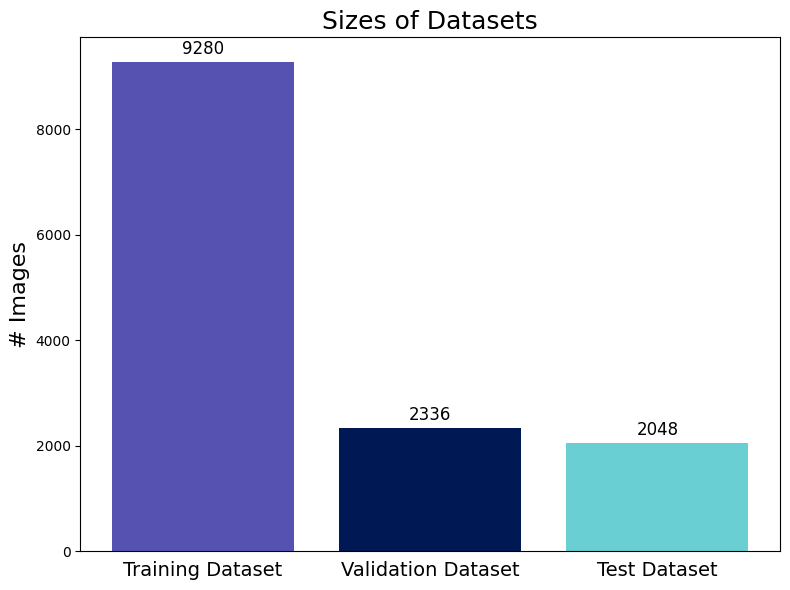

In [54]:
# Calculate the total number of images in each dataset
train_images = train_dataset.cardinality().numpy() * batch_size
validation_images = validation_dataset.cardinality().numpy() * batch_size
test_images = test_dataset.cardinality().numpy() * batch_size

# Set the labels and values for the bars
labels = ['Training Dataset', 'Validation Dataset', 'Test Dataset']
values = [train_images, validation_images, test_images]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bar chart
b = ax.bar(labels, values, color=['#5652b2', '#001853', '#69cfd3'])

# Customize the plot
ax.set_ylabel('# Images', fontsize=16)
ax.set_title('Sizes of Datasets', fontsize=18)
ax.tick_params(bottom=False, left=True)
# Increase the font size of x-axis tick labels
ax.tick_params(axis='x', labelsize=14)

# Add text labels on top of the bars
for rect in b:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

#### Anzahl der Bilder pro Klasse

['end_speed', 'no_class', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']


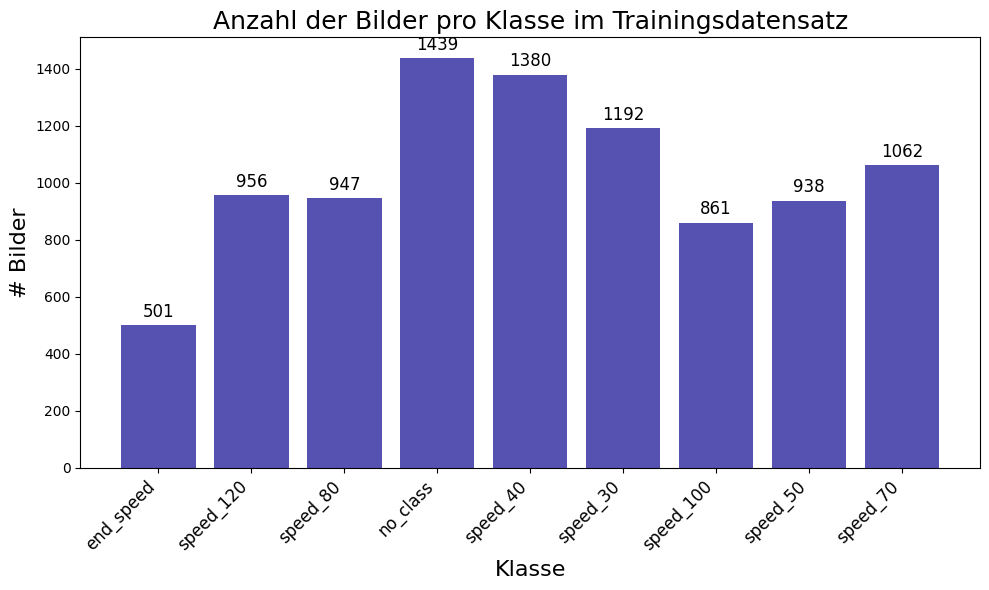

In [55]:
class_names = train_dataset.class_names
print(class_names)

# Anzahl der Bilder pro Klasse im Trainingsdatensatz
class_counts = {}
for images, labels in train_dataset:
    for label in labels.numpy():
        class_idx = tf.argmax(label).numpy()
        class_name = train_dataset.class_names[class_idx]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

# Diagramm für die Anzahl der Bilder pro Klasse
fig, ax = plt.subplots(figsize=(10, 6))

# Extrahieren der Klassen und zugehörigen Anzahlen
classes, counts = zip(*class_counts.items())
class_names = list(classes)

b = ax.bar(class_names, counts, color='#5652b2')

# Customize the plot
ax.set_xlabel('Klasse', fontsize=16)
ax.set_ylabel('# Bilder', fontsize=16)
ax.set_title('Anzahl der Bilder pro Klasse im Trainingsdatensatz', fontsize=18)
ax.tick_params(bottom=True, left=True)
ax.set_xticks(class_names)
ax.set_xticklabels(class_names, fontsize=12, rotation=45, ha="right")

# Add text labels on top of the bars
for rect in b:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

Enable prefetching for faster batch processing

In [56]:
AUTOTUNE = tf.data.AUTOTUNE


train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Create own model

In [38]:
input_shape = (desired_height, desired_width, 3)

own_model_shallow = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Rescaling-Schicht hinzufügen
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')  # Use softmax for multi-class classification
])

In [39]:
# create callbacks by calling the previously defined functions
checkpoint_callback = create_checkpoint('own_model_shallow')
earlystopping_callback = create_early_stopping(10)

#### Compile and train model

In [40]:
own_model_shallow.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # For multi-class classification
    metrics=['accuracy']
)

In [41]:
# Record the start time
start_time = time.time()

history_own_model_shallow = own_model_shallow.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=100,
  callbacks=[
    checkpoint_callback,
    earlystopping_callback
    ]
)

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/100


290/290 [==============================] - ETA: 0s - loss: 1.0406 - accuracy: 0.6325
Epoch 1: val_accuracy improved from -inf to 0.87107, saving model to models\own_model_shallow.h5
290/290 [==============================] - 7s 13ms/step - loss: 1.0406 - accuracy: 0.6325 - val_loss: 0.3946 - val_accuracy: 0.8711
Epoch 2/100
284/290 [============================>.] - ETA: 0s - loss: 0.2533 - accuracy: 0.9251
Epoch 2: val_accuracy improved from 0.87107 to 0.95257, saving model to models\own_model_shallow.h5
290/290 [==============================] - 4s 12ms/step - loss: 0.2534 - accuracy: 0.9249 - val_loss: 0.2079 - val_accuracy: 0.9526
Epoch 3/100
290/290 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9641
Epoch 3: val_accuracy improved from 0.95257 to 0.95300, saving model to models\own_model_shallow.h5
290/290 [==============================] - 4s 13ms/step - loss: 0.1198 - accuracy: 0.9641 - val_loss: 0.1930 - val_accuracy: 0.9530
Epoch 4/100
290/290 [=======

##### Evaluate

Training time until best accuracy: 146.9452 seconds and 19 epochs
64/64 [==============================] - 1s 7ms/step - loss: 0.1764 - accuracy: 0.9829


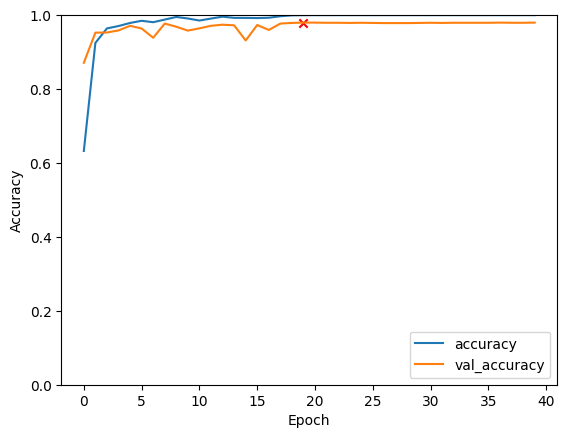

In [42]:
evaluate_model(history_own_model_shallow, own_model_shallow, 'own_model_shallow', training_time, test_dataset)

### Create a deeper model with more layers

In [63]:
input_shape = (desired_height, desired_width, 1)

own_model_deeper = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape, data_format='channels_last'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')  # Change to softmax for multi-class classification
])

own_model_deeper.build(input_shape)
own_model_deeper.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                      

In [64]:
# create callbacks by calling the previously defined functions
checkpoint_callback = create_checkpoint('own_model_deeper')
earlystopping_callback = create_early_stopping(20)

own_model_deeper.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

  # Record the start time
start_time = time.time()

history_own_model_deeper = own_model_deeper.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=100,
  callbacks=[
    checkpoint_callback,
    earlystopping_callback
  ]
)

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/100


290/290 [==============================] - ETA: 0s - loss: 2.3465 - accuracy: 0.3283
Epoch 1: val_accuracy improved from -inf to 0.48987, saving model to models\own_model_deeper.h5
290/290 [==============================] - 8s 24ms/step - loss: 2.3465 - accuracy: 0.3283 - val_loss: 1.5508 - val_accuracy: 0.4899
Epoch 2/100
288/290 [============================>.] - ETA: 0s - loss: 1.2346 - accuracy: 0.5430
Epoch 2: val_accuracy improved from 0.48987 to 0.76024, saving model to models\own_model_deeper.h5
290/290 [==============================] - 5s 18ms/step - loss: 1.2341 - accuracy: 0.5430 - val_loss: 0.7777 - val_accuracy: 0.7602
Epoch 3/100
286/290 [============================>.] - ETA: 0s - loss: 0.8041 - accuracy: 0.7072
Epoch 3: val_accuracy improved from 0.76024 to 0.89694, saving model to models\own_model_deeper.h5
290/290 [==============================] - 5s 17ms/step - loss: 0.8023 - accuracy: 0.7080 - val_loss: 0.3425 - val_accuracy: 0.8969
Epoch 4/100
289/290 [==========

Training time until best accuracy: 293.7077 seconds and 37 epochs
64/64 [==============================] - 1s 11ms/step - loss: 0.0931 - accuracy: 0.9843


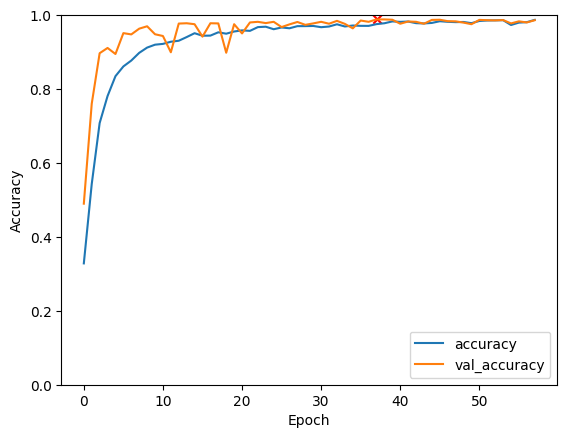

In [65]:
evaluate_model(history_own_model_deeper, own_model_deeper, 'own_model_deeper', training_time, test_dataset)

#### Use a pre-trained network - Transfer Learning

In [57]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (desired_width, desired_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


Preprocessing layer:

In [58]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Freeze or unfreeze the convolutional base

In [59]:
base_model.trainable = True
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

Add the classification head for sign classification

In [61]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# convert features to single 1280 element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(number_of_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


ValueError: Exception encountered when calling layer "mobilenetv2_1.00_128" "                 f"(type Functional).

Input 0 of layer "Conv1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (32, 128, 128, 1)

Call arguments received by layer "mobilenetv2_1.00_128" "                 f"(type Functional):
  • inputs=tf.Tensor(shape=(32, 128, 128, 1), dtype=float32)
  • training=False
  • mask=None

Build the model:
* add a resizing layer as the Network was trained on images with the size of 160x160

In [75]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [76]:
print(f"There are {len(model.trainable_variables)} layers trainable")
tf.keras.utils.plot_model(model, show_shapes=True)

There are 158 layers trainable
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Compile the model:

In [77]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])


First evaluate the model:

In [78]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


73/73 [==============================] - 2s 15ms/step - loss: 2.8001 - accuracy: 0.1466
initial loss: 2.80
initial accuracy: 0.15


The accuracy is expected. As there are 9 categories, the model just guesses one of them which is about 10-12% correct.

Now finetuning is done:

In [79]:
# create callbacks by calling the previously defined functions
checkpoint_callback = create_checkpoint('MobileNet')
earlystopping_callback = create_early_stopping(10)

# Record the start time
start_time = time.time()

history_mobilenet = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=[
                    checkpoint_callback,
                    earlystopping_callback]
                    )

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/100


290/290 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.7648
Epoch 1: val_accuracy improved from -inf to 0.91332, saving model to models\MobileNet.h5
290/290 [==============================] - 19s 51ms/step - loss: 0.6599 - accuracy: 0.7648 - val_loss: 0.2346 - val_accuracy: 0.9133
Epoch 2/100
289/290 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9440
Epoch 2: val_accuracy improved from 0.91332 to 0.96033, saving model to models\MobileNet.h5
290/290 [==============================] - 14s 50ms/step - loss: 0.1600 - accuracy: 0.9440 - val_loss: 0.1174 - val_accuracy: 0.9603
Epoch 3/100
290/290 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9768
Epoch 3: val_accuracy improved from 0.96033 to 0.97887, saving model to models\MobileNet.h5
290/290 [==============================] - 14s 49ms/step - loss: 0.0687 - accuracy: 0.9768 - val_loss: 0.0737 - val_accuracy: 0.9789
Epoch 4/100
289/290 [============================

### Load the saved models from disc if desired to make predictions

64/64 [==============================] - 1s 13ms/step - loss: 0.0216 - accuracy: 0.9951
Training time until best accuracy: 352.1639 seconds and 14 epochs
64/64 [==============================] - 1s 14ms/step - loss: 0.0216 - accuracy: 0.9951


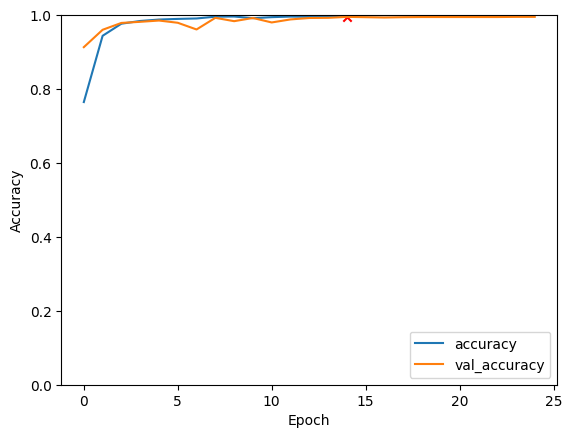

In [81]:
evaluate_model(history_mobilenet, model, 'MobileNet', training_time, test_dataset)

In [3]:
models =  {
    'own_model_shallow', 'own_model_deeper', 'MobileNet'
}


load_from_disc = True
own_model_shallow = None
own_model_deeper = None

if load_from_disc:
    model_path_shallow = os.path.join("models/", 'own_model_shallow.h5')
    model_path_deep = os.path.join("models/", 'own_model_deeper.h5')
    model_path_mobileNet = os.path.join("models/", 'MobileNet.h5')
    own_model_shallow = tf.keras.models.load_model(model_path_shallow)
    own_model_deeper = tf.keras.models.load_model(model_path_deep)
    own_model_mobileNet = tf.keras.models.load_model(model_path_mobileNet)


#### Measure the time required for one prediction

2/2 [==============================] - 0s 257ms/step
Average prediction time: 0.0039 seconds


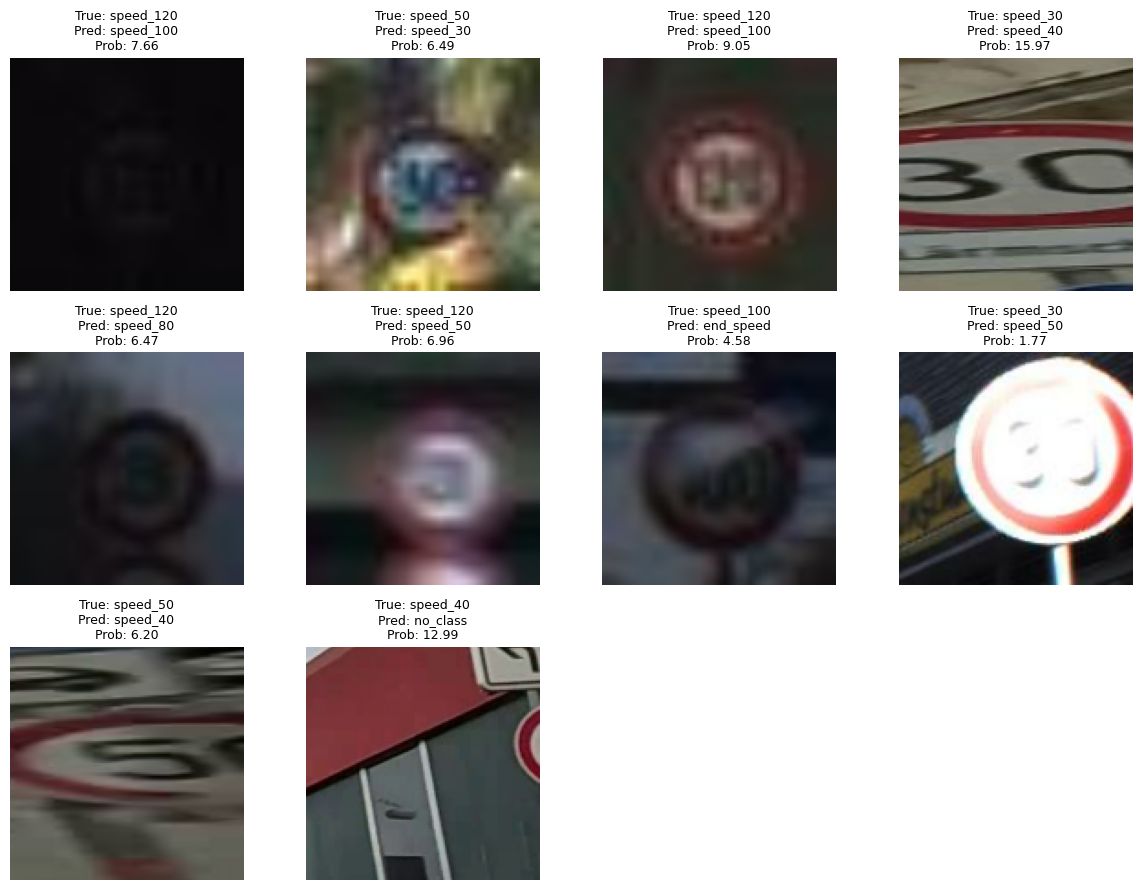

In [9]:
plot_misclassified_images_with_filenames(own_model_mobileNet, 100)

In [66]:
image_path = r'C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\test\speed_50\00000_00027.jpg'

# Load the image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)image = cv2.resize(image, (128, 128))
# Add batch dimension to match the expected input shape (1, 128, 128, 3)
input_data = np.expand_dims(image, axis=0)

start_time = time.time()
pred_probs = own_model_deeper.predict(input_data)
end_time = time.time()
print(f"required time: {end_time-start_time}")

pred_label = np.argmax(pred_probs)

# Plotten der falsch klassifizierten Bilder

plt.imshow(image)
plt.title(f"Pred: {class_names[pred_label]}\nProb: {np.max(pred_probs):.2f}", fontsize=9)
plt.axis("off")

plt.tight_layout()
plt.show()

ValueError: in user code:

    File "c:\Users\aaron\anaconda3\envs\machine_vision_tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\aaron\anaconda3\envs\machine_vision_tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\aaron\anaconda3\envs\machine_vision_tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\aaron\anaconda3\envs\machine_vision_tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\aaron\anaconda3\envs\machine_vision_tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\aaron\anaconda3\envs\machine_vision_tf\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_1" "                 f"(type Sequential).
    
    Input 0 of layer "conv2d_3" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 128, 128, 3)
    
    Call arguments received by layer "sequential_1" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=uint8)
      • training=False
      • mask=None


## Networks with Data Augmentation

Training the network with augmented data (3x data samples)

Load the augmented datasets

In [92]:
batch_size = 32

# Laden der Bilder und Labels aus den Unterordnern
print("Training dataset:")
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=augmented_images_data_folder,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

print("\nValidation dataset:")
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=augmented_images_data_folder,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

print("\nTest dataset:")
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_data_folder,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

Training dataset:
Found 27111 files belonging to 9 classes.
Using 21689 files for training.

Validation dataset:
Found 27111 files belonging to 9 classes.
Using 5422 files for validation.

Test dataset:
Found 2041 files belonging to 9 classes.


In [93]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (desired_width, desired_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# preprocessing and unfreezing of the base layer
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model.trainable = True
base_model.summary()

# add classification head:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# convert features to single 1280 element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(number_of_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_11[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

Create the model

In [94]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [95]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])


# create callbacks by calling the previously defined functions
checkpoint_callback = create_checkpoint('MobileNetAugmented')
earlystopping_callback = create_early_stopping(10)

# Record the start time
start_time = time.time()

history_mobilenet_aug = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=[
                    checkpoint_callback,
                    earlystopping_callback]
                    )

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/100
678/678 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.8424
Epoch 1: val_accuracy improved from -inf to 0.94246, saving model to models\MobileNetAugmented.h5
678/678 [==============================] - 39s 52ms/step - loss: 0.4306 - accuracy: 0.8424 - val_loss: 0.1685 - val_accuracy: 0.9425
Epoch 2/100
677/678 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9704
Epoch 2: val_accuracy improved from 0.94246 to 0.98525, saving model to models\MobileNetAugmented.h5
678/678 [==============================] - 33s 49ms/step - loss: 0.0892 - accuracy: 0.9704 - val_loss: 0.0452 - val_accuracy: 0.9852
Epoch 3/100
678/678 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9826
Epoch 3: val_accuracy improved from 0.98525 to 0.98727, saving model to models\MobileNetAugmented.h5
678/678 [==============================] - 33s 49ms/step - loss: 0.0522 - accuracy: 0.9826 - val_loss: 0.0358 - val_accuracy: 0.9873
Epoch 4/10

Training time until best accuracy: 699.2229 seconds and 10 epochs
2/2 [==============================] - 0s 12ms/step


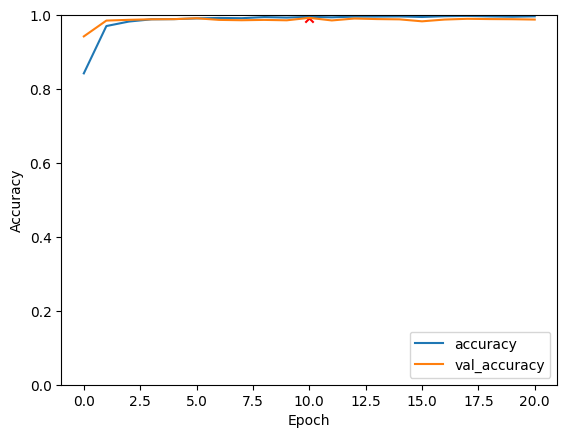

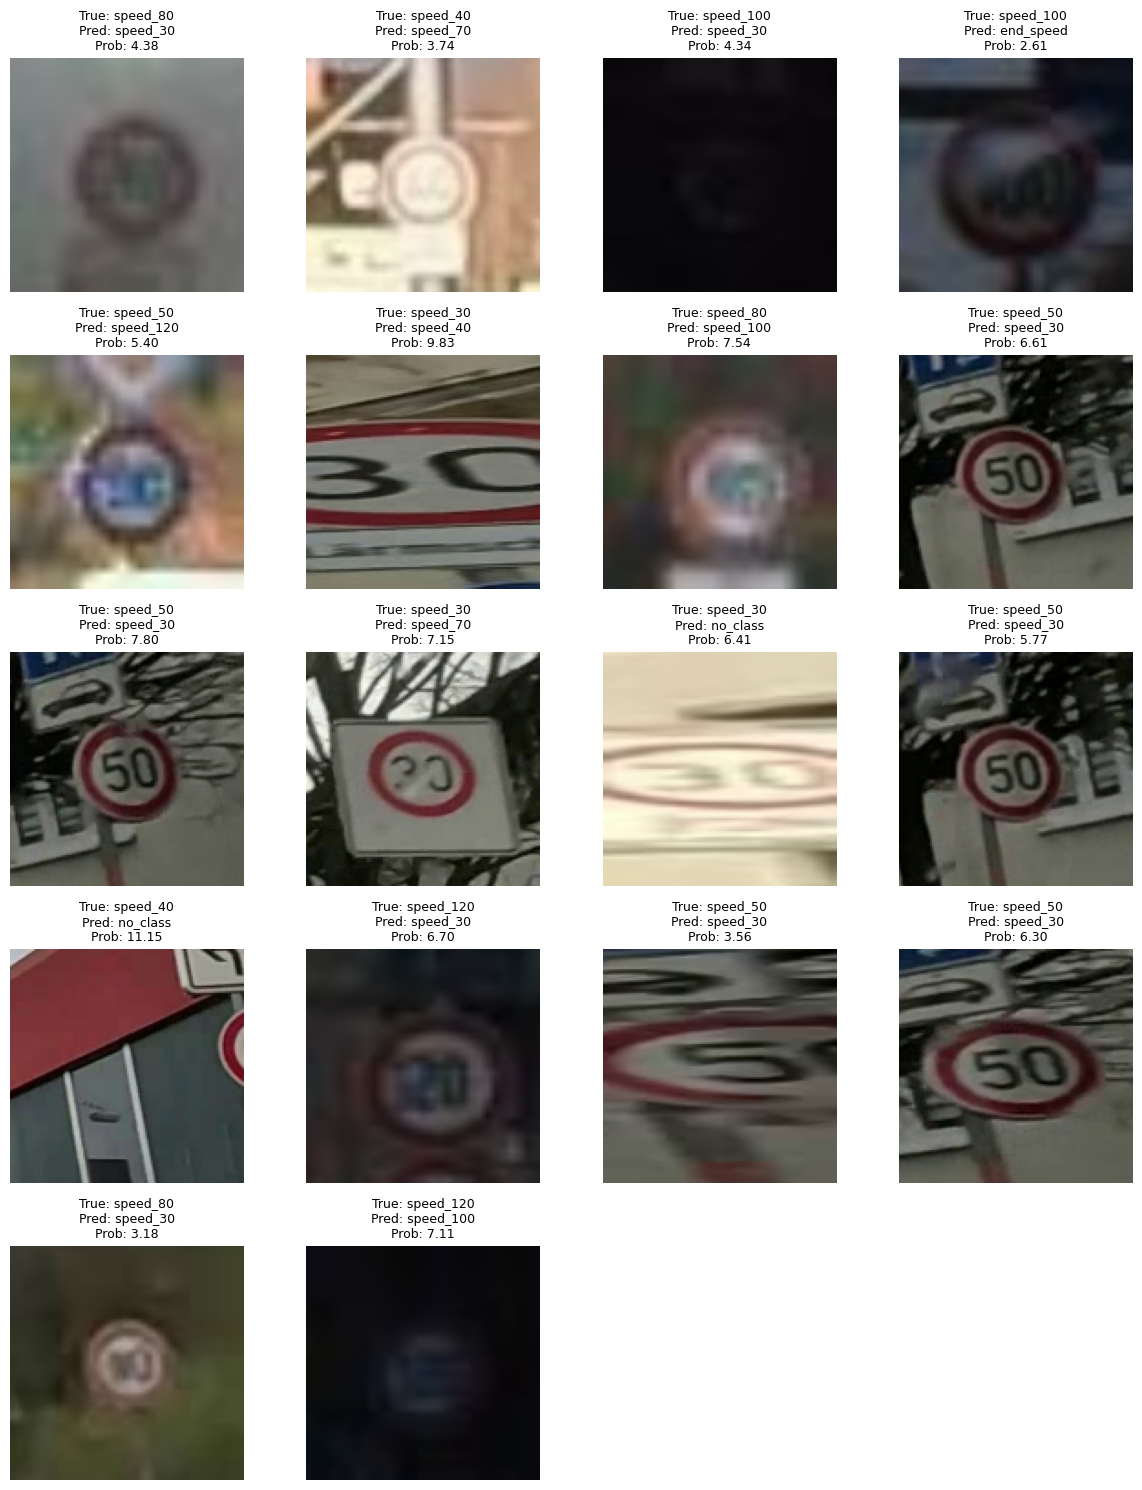

In [98]:
evaluate_model(history_mobilenet_aug, model, 'MobileNetAugmented', training_time, test_dataset)

plot_misclassified_images_with_filenames(model, 100)